# Obtaining maximum likelihood estimate using evolutionary algorithm

Sometime it is useful to start somewhere close to the high likelihood region. In this tutorial, we use a built-in evolutionary algorithm to find the maximum likelihood estimate of the model parameters.


In [5]:
import jax
import jax.numpy as jnp  # JAX NumPy
from jax.scipy.special import logsumexp
from flowMC.utils.EvolutionaryOptimizer import EvolutionaryOptimizer

def target_dualmoon(x, data):
    """
    Term 2 and 3 separate the distribution and smear it along the first and second dimension
    """
    print("compile count")
    term1 = 0.5 * ((jnp.linalg.norm(x-data) - 2) / 0.1) ** 2
    term2 = -0.5 * ((x[:1] + jnp.array([-3.0, 3.0])) / 0.8) ** 2
    term3 = -0.5 * ((x[1:2] + jnp.array([-3.0, 3.0])) / 0.6) ** 2
    return -(term1 - logsumexp(term2) - logsumexp(term3))

n_dim = 5 
n_loops = 100
popsize = 100
bounds = jnp.array([[-10,10]]*n_dim)

optimizer = EvolutionaryOptimizer(n_dim, popsize=popsize, verbose = True)
y = jax.jit(jax.vmap(lambda x: -target_dualmoon(x, jnp.zeros(n_dim))))
state = optimizer.optimize(y, bounds, n_loops=n_loops)
best_fit = optimizer.get_result()[0]

Generation:   0%|          | 0/100 [00:00<?, ?it/s]

compile count


Generation: 99, Fitness: 5.1406: 100%|██████████| 100/100 [00:03<00:00, 29.44it/s]


In [3]:
print(best_fit)

[-1.2174921e+00 -1.6453047e+00  3.6048889e-04 -4.7874451e-04
  2.8228760e-04]


# Let's compare the maximum likelihood to the posterior

In [10]:
from flowMC.nfmodel.rqSpline import MaskedCouplingRQSpline
from flowMC.nfmodel.utils import *
from flowMC.sampler.MALA import MALA
from flowMC.sampler.Sampler import Sampler
from flowMC.utils.PRNG_keys import initialize_rng_keys

n_chains = 20
n_loop_training = 5
n_loop_production = 5
n_local_steps = 100
n_global_steps = 100
learning_rate = 0.001
momentum = 0.9
num_epochs = 30
batch_size = 10000

data = jnp.zeros(n_dim)


rng_key_set = initialize_rng_keys(n_chains, 42)
model = MaskedCouplingRQSpline(n_dim, 4, [32,32], 8 , jax.random.PRNGKey(10))

initial_position = jax.random.normal(rng_key_set[0], shape=(n_chains, n_dim)) * 1

MALA_Sampler = MALA(target_dualmoon, True, {"step_size": 0.1})

print("Initializing sampler class")

nf_sampler = Sampler(
    n_dim,
    rng_key_set,
    jnp.zeros(5),
    MALA_Sampler,
    model,
    n_loop_training=n_loop_training,
    n_loop_production=n_loop_production,
    n_local_steps=n_local_steps,
    n_global_steps=n_global_steps,
    n_chains=n_chains,
    n_epochs=num_epochs,
    learning_rate=learning_rate,
    momentum=momentum,
    batch_size=batch_size,
    use_global=True,
)

nf_sampler.sample(initial_position, data)

Initializing sampler class
jit is requested, precompiling kernels and update...
compile count
compile count
No autotune found, use input sampler_params
Training normalizing flow


Tuning global sampler:  20%|██        | 1/5 [00:10<00:42, 10.50s/it]

compile count


Tuning global sampler: 100%|██████████| 5/5 [00:14<00:00,  2.99s/it]


Starting Production run


Production run: 100%|██████████| 5/5 [00:00<00:00, 29.09it/s]


Text(0.5, 0.98, 'Visualize samples')

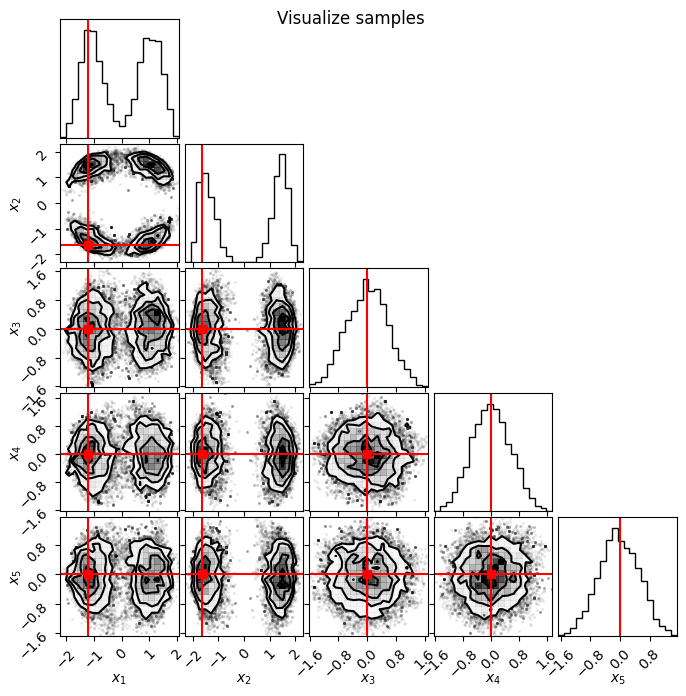

In [11]:
import corner
import matplotlib.pyplot as plt
import numpy as np

chains = np.array(nf_sampler.get_sampler_state(training=False)["chains"])

labels=["$x_1$", "$x_2$", "$x_3$", "$x_4$", "$x_5$"]
# Plot all chains
figure = corner.corner(
    chains.reshape(-1, n_dim), labels=labels, truths=best_fit, truth_color="red"
)
figure.set_size_inches(7, 7)
figure.suptitle("Visualize samples")